# Generating Investigative Leads from DNA Data
#### <i>Mapping Forensic Y-Short Tandem Repeats to Haplogroups (Ethnicities)</i>

## Abstract


Genetic markers, particularly Y-chromosome short tandem repeats (Y-STRs), play a critical role in forensic investigations. Because Y-STRs are inherited strictly along the paternal line, it can help differentiate male lineages. However, its forensic value depends heavily on the availability of reference profiles in population databases. When no corresponding entry exists, a generated Y-STR profile cannot be used for direct identification.

This study addresses this limitation by proposing an alternative approach: **mapping Y-STRs to haplogroups**. Haplogroups represent major branches of the paternal lineage and can provide informative ancestral context even in the absence of an exact database match.

Key concepts include:
1. Y-chromosome: The chromosome that is passed down from father to son, and is present only in males
2. Y-STRs: Repetitive DNA patterns on the Y-chromosome
3. Haplogroups: Defines the largest branches on the paternal family tree, which can be treated as a 'genetic ethnicity' (e.g., East Asian, Western European, etc.)

By using machine learning to map Y-STR profiles to haplogroups, this approach enables investigators to extract meaningful lineage information and helps in ruling out or including a person in a suspect list.

## Data Source

The dataset utilized in the study originates from the supplementary material of YHP: Y-chromosome Haplogroup Predictor (Song et al., 2024), which trained machine-learning models to predict Y-SNP haplogroups from Y-STR haplotypes [1].

Below are the following information about the dataset:
1. 4064 total rows

2. 27 features (e.g. DYS576, DYS389 I)
    - Values: Allele Counts (int)

3. 13 targets
    - Major Haplogroups (e.g. O, C, G)

Other columns included are the following:
- Total Frequency
- Haplotype
- Sample ID
- Population
- Frequency

## Methodology

Step 1. Conduct Exploratory Data Analysis

Step 2. Identify Machine Learning Models to use

Step 3. Identify Key Evaluation Metrics

Step 4. Build and Test Machine Learning Models

### 1. Exploratory Data Analysis

Exploratory Data Analysis (EDA) was conducted to understand the structure, quality, and underlying patterns within the dataset. The dataset comprises multiple categorical and numerical variables, including haplogroup labels, population information, and allele repeat counts for several Y-STR genetic markers.

The goal of this analysis is to examine the distribution and variability of these markers across haplogroups and populations, assess data completeness, and identify potential relationships among genetic features. By systematically exploring marker distributions, inter-marker correlations, and population-level differences, this EDA aims to determine whether the dataset exhibits structured and non-random patterns which serves as empirical evidence for the feasibility of predictive modeling using machine learning.

In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

In [9]:
# Step 1. Load dataset
df = pd.read_excel('Supplemental Processed Data Set.xlsx', sheet_name='S Table 1', skiprows=1)

# Step 2. Fill NaN values
df = df.ffill()

# Step 3. Split haplotype into separate columns
df = pd.concat([df, df['haplotype'].str.replace('[', '').str.replace(']', '').str.split(',', expand=True)], axis=1)
YSTRs = {0: "DYS576", 1: "DYS389 I", 2: "DYS635", 3: "DYS389 II", 4: "DYS627", 5: "DYS460", 6: "DYS458",
                 7: "DYS19", 8: "Y-GATA-H4", 9: "DYS448", 10: "DYS391", 11: "DYS456", 12: "DYS390", 13: "DYS438", 
                 14: "DYS392", 15: "DYS518", 16: "DYS570", 17: "DYS437", 18: "DYS385a", 19: "DYS385b", 20: "DYS449", 
                 21: "DYS393", 22: "DYS439", 23: "DYS481", 24: "DYS576a", 25: "DYS576b", 26: "DYS533"
}

df = df.rename(columns=YSTRs)
df = df.drop(columns=['haplotype'])

# Step 4. Identify major haplogroups
hap_col = df.columns[0]
df["major_haplogroup"] = df[hap_col].str.extract(r"^([A-Z])")
df


,haplogroup,number_of_haplotypes,total_frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,DYS385a,DYS385b,DYS449,DYS393,DYS439,DYS481,DYS576a,DYS576b,DYS533,major_haplogroup
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,11.0,19.0,30.0,14.0,12.0,24.0,36.0,39.0,12.0,C
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0,C
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,11.0,19.0,30.0,14.0,12.0,23.0,37.0,38.0,12.0,C
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0,C
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,14.0,18.0,32.0,11.0,13.0,23.0,35.0,37.0,11.0,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,13.0,13.0,31.0,13.0,11.0,25.0,37.0,40.0,11.0,O
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,12.0,19.0,31.0,12.0,12.0,28.0,36.0,38.0,11.0,O
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,12.0,19.0,33.0,12.0,12.0,26.0,36.0,39.0,11.0,O
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,12.0,18.0,29.0,14.0,12.0,23.0,37.0,39.0,11.0,O


#### 2.1 Data Overview

Shape:(4064, 34)

Count of missing values in dataset: 0



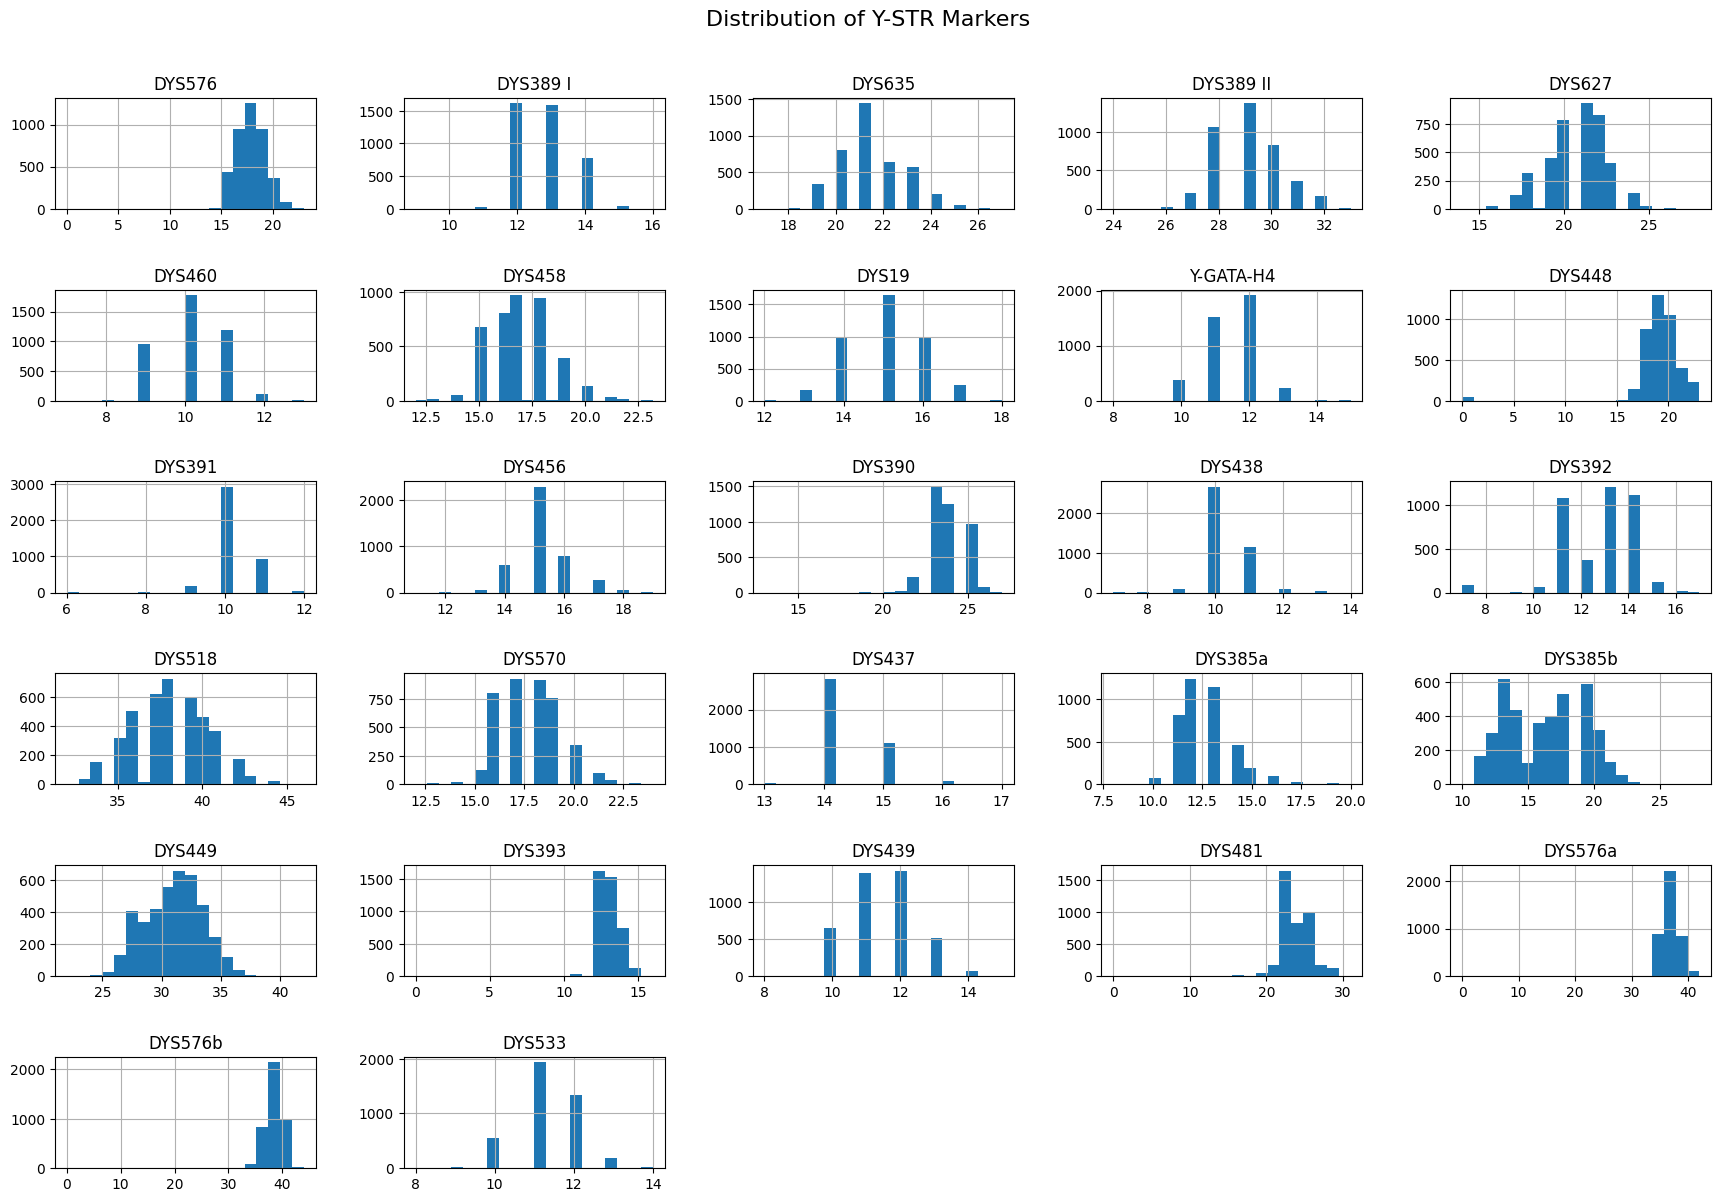

In [6]:
print(f"Shape:{df.shape}")
print(f"\nCount of missing values in dataset: {df.isna().sum().sum()}\n")

marker_cols = ['DYS576', 'DYS389 I', 'DYS635', 'DYS389 II', 'DYS627', 'DYS460', 'DYS458',
                 'DYS19', 'Y-GATA-H4', 'DYS448', 'DYS391', 'DYS456', 'DYS390', 'DYS438', 
                 'DYS392', 'DYS518', 'DYS570', 'DYS437', 'DYS385a', 'DYS385b', 'DYS449', 
                 'DYS393', 'DYS439', 'DYS481', 'DYS576a', 'DYS576b', 'DYS533']
# id_cols = ['haplogroup', 'population', 'sampleID']
# num_cols = ['number of haplotypes', 'total frequency', 'frequency']

df[marker_cols] = df[marker_cols].apply(pd.to_numeric, errors='coerce')
df[marker_cols].hist(figsize=(18, 12), bins=20)
plt.tight_layout(pad=3.0, w_pad=2.0, h_pad=2.5)
plt.suptitle("Distribution of Y-STR Markers", fontsize=16, y=1.02)
plt.show()

<b> Analysis </b>

The dataset comprises a total of 4,064 observations. Following data preprocessing, the final structure consists of 33 variables. A check for missing values showed that all columns are complete, making the dataset ready for analysis.

The Y-STR marker distributions reveal a mix of allele patterns across different loci. Some markers, like DYS449, DYS458, and DYS385a/b, show wide and often multimodal distributions, suggesting higher genetic diversity and stronger potential to distinguish between haplogroups or populations. In contrast, markers such as DYS391, DYS393, and DYS437 are more narrowly distributed, indicating conserved loci that contribute stability but less variation. Overall, the distinct and structured differences observed across markers point to meaningful genetic variation in the dataset, supporting its suitability for further modeling and classification analysis.

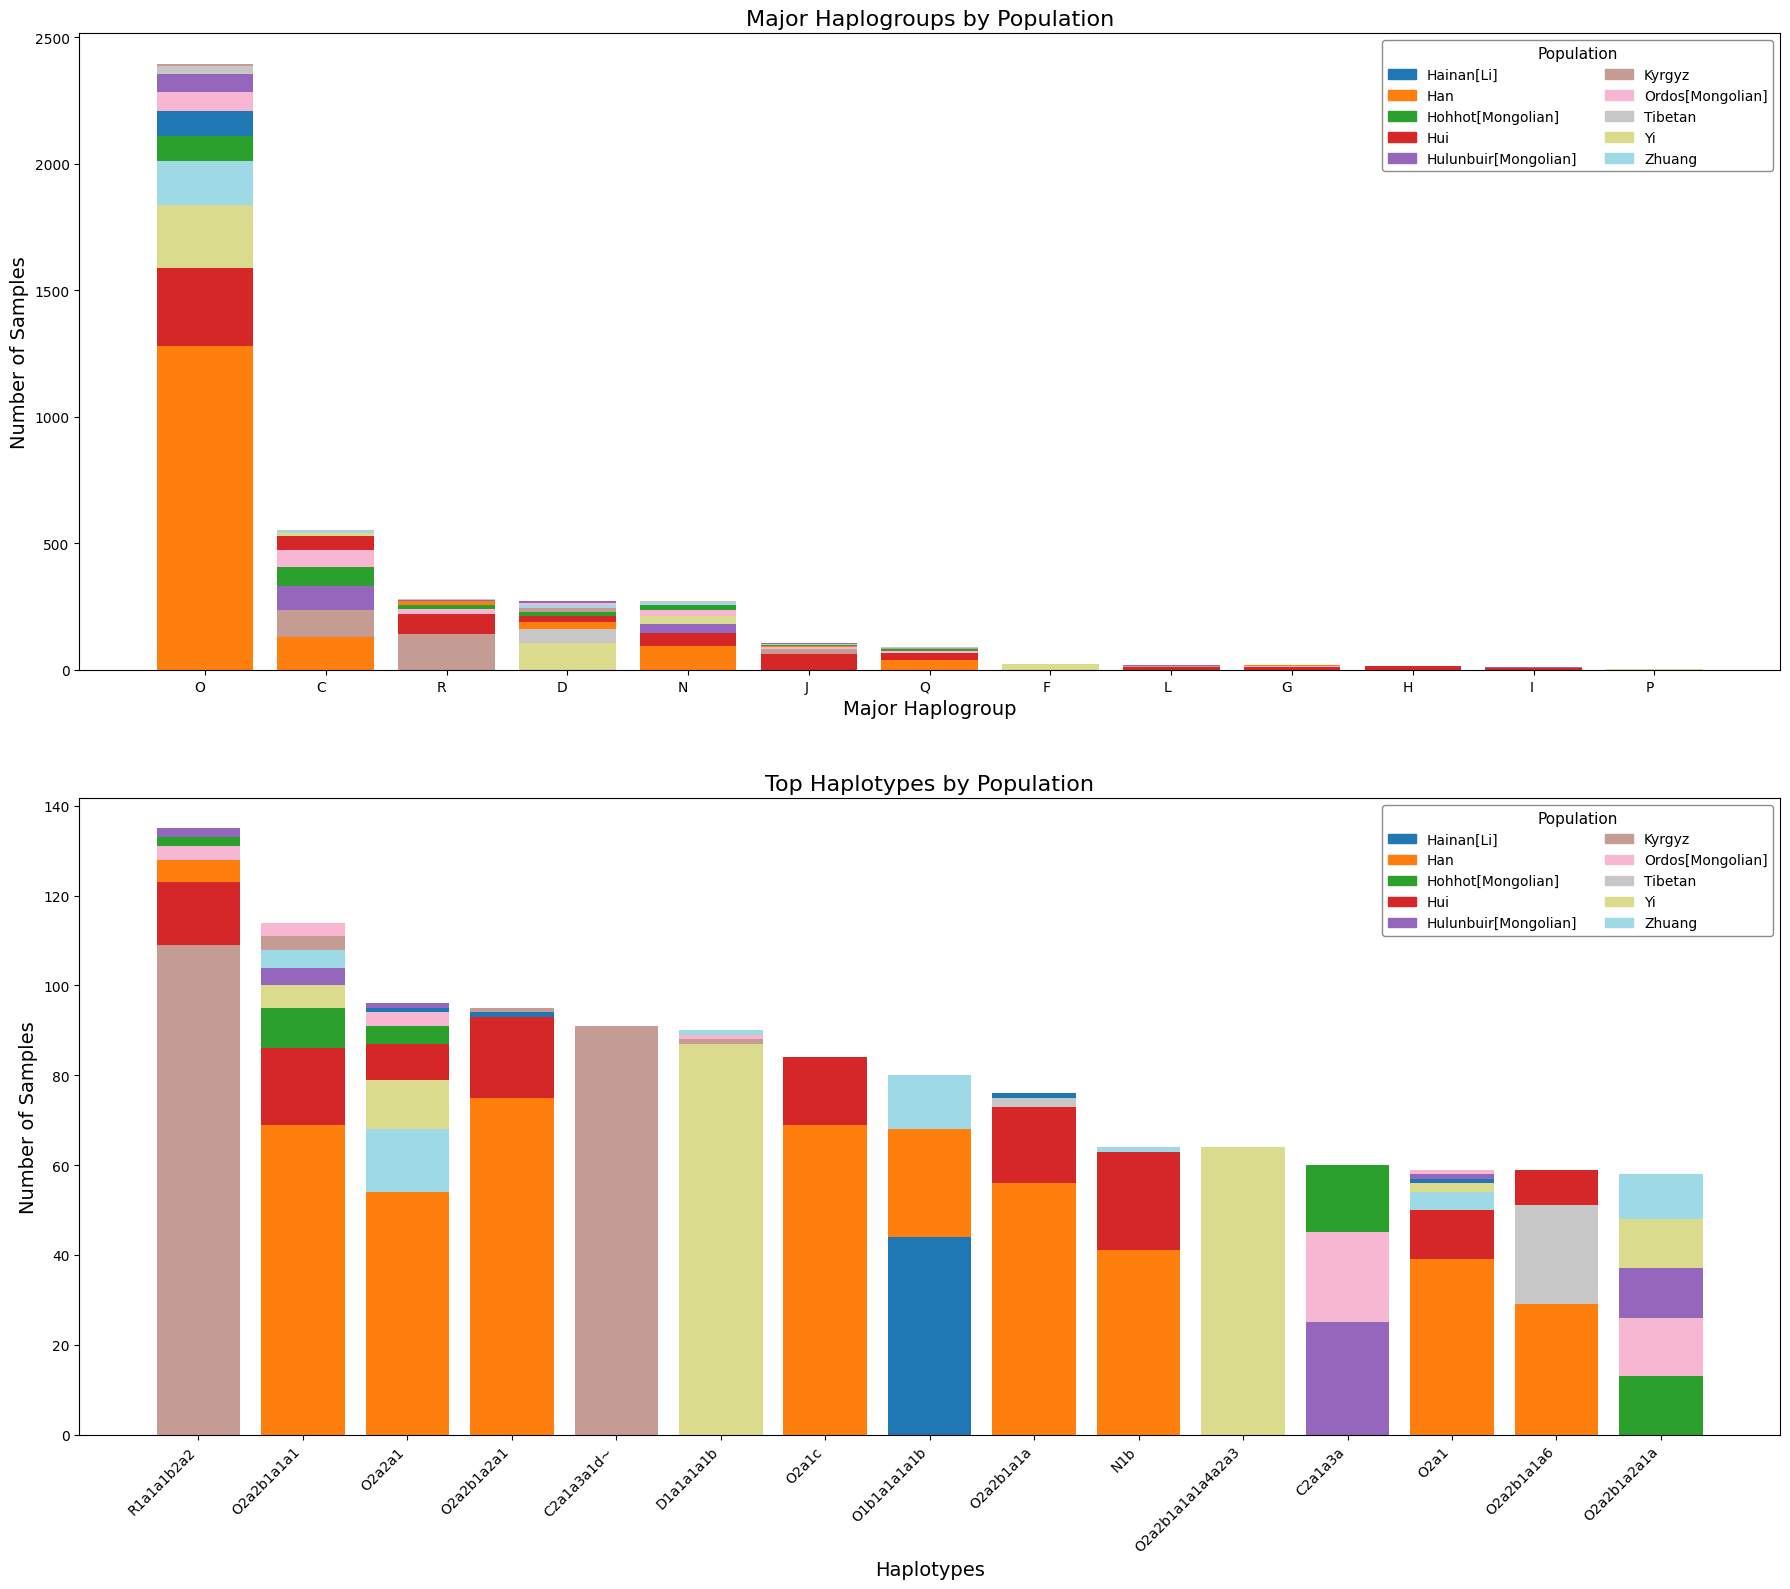

In [8]:
# Create combined figure with two subplots (top and bottom)
fig, axes = plt.subplots(2, 1, figsize=(18, 16))  # 2 rows, 1 column

# ---------- TOP PLOT: Major Haplogroups ----------
grouped_major = df.groupby(['major_haplogroup', 'population']).size().unstack(fill_value=0)
top_major = grouped_major.sum(axis=1).nlargest(15).index
grouped_major_top = grouped_major.loc[top_major]

# Assign colors
populations = grouped_major_top.columns
colors = plt.cm.tab20(np.linspace(0, 1, len(populations)))
color_map = dict(zip(populations, colors))

# Plot
x = np.arange(len(grouped_major_top))
bottom = np.zeros(len(grouped_major_top))

for i in range(len(grouped_major_top)):
    row = grouped_major_top.iloc[i].sort_values(ascending=False)
    for pop, value in row.items():
        if value > 0:
            axes[0].bar(x[i], value, bottom=bottom[i], color=color_map[pop], width=0.8)
            bottom[i] += value

# Format top plot
axes[0].set_xticks(x)
axes[0].set_xticklabels(grouped_major_top.index, rotation=360, ha='right')
axes[0].set_title("Major Haplogroups by Population", fontsize=16)
axes[0].set_xlabel("Major Haplogroup", fontsize=14)
axes[0].set_ylabel("Number of Samples", fontsize=14)

# Legend (inside top plot)
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[pop]) for pop in populations]
legend = axes[0].legend(
    handles, populations,
    title="Population",
    loc='upper right',
    frameon=True,
    fontsize=10,
    title_fontsize=11,
    ncol=2
)
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor('gray')

# ---------- BOTTOM PLOT: Haplogroups ----------
grouped_hap = df.groupby(['haplogroup', 'population']).size().unstack(fill_value=0)
top_haps = grouped_hap.sum(axis=1).nlargest(15).index
grouped_hap_top = grouped_hap.loc[top_haps]

# Plot
x = np.arange(len(grouped_hap_top))
bottom = np.zeros(len(grouped_hap_top))

for i in range(len(grouped_hap_top)):
    row = grouped_hap_top.iloc[i].sort_values(ascending=False)
    for pop, value in row.items():
        if value > 0:
            axes[1].bar(x[i], value, bottom=bottom[i], color=color_map[pop], width=0.8)
            bottom[i] += value

# Format bottom plot
axes[1].set_xticks(x)
axes[1].set_xticklabels(grouped_hap_top.index, rotation=45, ha='right')
axes[1].set_title("Top Haplotypes by Population", fontsize=16)
axes[1].set_xlabel("Haplotypes", fontsize=14)
axes[1].set_ylabel("Number of Samples", fontsize=14)

# Legend (inside bottom plot)
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[pop]) for pop in populations]
legend = axes[1].legend(
    handles, populations,
    title="Population",
    loc='upper right',
    frameon=True,
    fontsize=10,
    title_fontsize=11,
    ncol=2
)
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor('gray')

# ---------- Final Layout ----------
plt.tight_layout(h_pad=4.0)  # Add space between plots
plt.show()

<b> Analysis </b>

The stacked bar chart highlights a clear class imbalance across haplogroups, with a few major lineages such as R1a1b2a2 and O2a2b1a1a1 contributing the majority of samples, while others appear far less frequently. Within these haplogroups, certain populations, particularly the Han, dominate the sample composition, resulting in uneven representation across both genetic and population groups. This type of imbalance is expected in Y-SNP and Y-STR datasets, as haplogroup frequencies reflect deep historical and demographic patterns, including population expansions, founder effects, and region-specific sampling priorities. Larger datasets and public repositories also tend to oversample major lineages associated with well-studied populations, further reinforcing this skew.

Despite this imbalance, developing a machine learning model remains highly beneficial. Properly designed models can help identify subtle genetic patterns within underrepresented haplogroups, highlight population-specific variations, and support predictive classification when new Y-chromosomal profiles are encountered. Techniques such as stratified sampling, class weighting, or oversampling can mitigate bias, allowing the model to generalize beyond the dominant haplogroups. In this way, machine learning serves as a powerful analytical tool to handle the inherent imbalance while uncovering structure and diversity within complex Y-chromosomal data.

<b> Discussion: Class Imbalance & National Population Distribution </b>

The predominance of certain haplogroups and populations in the dataset is not merely a sampling artefact. It reflects the actual demographic and genetic composition of China. According to the Y-Chromosome Haplotype Reference Database (YHRD), China’s national database contains over 132,000 haplotypes, the largest national collection within YHRD [11]. Within this database, the Han Chinese meta-population accounts for the overwhelming majority of entries, with 98,957 haplotypes compared to only a few thousand from minority groups. Similarly, demographic data show that the Han ethnic group constitutes approximately 91% of China’s total population. This clear dominance at both the genetic and population levels helps explain the imbalance observed in the dataset.

Because Y-SNP and Y-STR data trace male lineage and paternal inheritance, haplogroups that are historically prevalent among the Han, such as O2 and its subclades, are naturally more frequent. In contrast, haplogroups associated with smaller ethnic minorities, such as Tibetan, Uyghur, or Mongolic lineages, are less represented. As a result, the dataset exhibits both between-class imbalance (some haplogroups having far more samples than others) and within-class imbalance (haplogroups dominated by one population, with limited diversity).

While such imbalance is expected due to historical demographic expansions, founder effects, and the concentration of YHRD submissions from major populations, it has implications for downstream modeling. A machine learning model trained directly on this data may overfit to the majority haplogroups and underperform for minority lineages. However, when properly handled—using stratified sampling, class weighting, or oversampling—machine learning can still uncover informative genetic patterns, identify rare variants, and support lineage prediction for underrepresented groups. Thus, even though the imbalance reflects China’s real population structure, modeling remains valuable for generalizing insights across both common and rare paternal lineages.

<b> Addressing Class Imbalance in the Data </b>

To manage the pronounced class imbalance in the Y-SNP/Y-STR dataset, we applied a singleton-handling procedure by dropping haplogroups represented by only one sample. These single-instance haplogroups, or singletons, offer limited statistical reliability and can introduce noise during model training, as the model cannot generalize from a class with no within-group variability. Removing them reduces the influence of outlier classes and allows the model to focus on haplogroups with sufficient representation for meaningful pattern learning. This approach improves both model stability and interpretability while retaining the dominant structure of the dataset.

While this reduces the total number of unique haplogroups, it yields a more balanced and analyzable dataset for machine learning. Combined with techniques such as stratified sampling during train-test splits and potential class weighting in model fitting, this preprocessing ensures that underrepresented but statistically meaningful haplogroups remain included, and that the final model reflects genuine lineage variation rather than noise from sparsely represented classes.

<b> From Mia: </b>

Hello, below blocks are not from me but I am not removing just in case it is needed :>

<b>From Francis:</b>

Hi, below blocks are from me HAHAHA I used the "Overlapping Classes" graph to justify why we won't be using Logistic Regression and SVM in section 2. Identify the Machine Learning Task

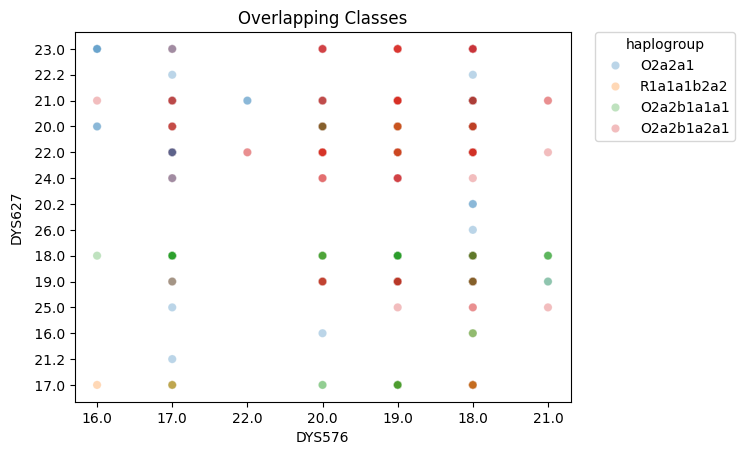

In [11]:
df_sample = df[(df['haplogroup'] == 'R1a1a1b2a2') | 
               (df['haplogroup'] == 'O2a2b1a1a1') | 
               (df['haplogroup'] == 'O2a2a1') | 
               (df['haplogroup'] == 'O2a2b1a2a1')]

ax = sns.scatterplot(data=df_sample, x='DYS576', y='DYS627', hue='haplogroup', alpha=0.3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title('Overlapping Classes')
plt.show()

Note that the points with mixed colors indicate classes having shared features. For example, DYS576 = 17.0 and DYS627 = 24.0 are shared by both O2a2a1 and O2a2b1a2a1.

#### 2.2 Data Preprocessing

### 3. Identify Key Evaluation Metrics

<i>Model Evaluation Metrics for Y-STR Haplogroup Classification</i>

**Overview**

To evaluate the performance of classifiers trained on Y-STR data, a suite of **multi-class performance metrics** designed to capture accuracy, balance, and generalization across unevenly distributed haplogroups is employed.

The dataset exhibits **hierarchical class structure** (Y-SNP Haplogroups to subclades/haplotypes) and **class imbalance** (some haplogroups and haplotypes have far fewer samples).

Therefore, standard accuracy alone is insufficient to adequately measure the performance of the model. Therefore, we also measured **macro-averaged F1**, **balanced accuracy**, and **Matthews Correlation Coefficient (MCC)** provide a more robust evaluation.

---

2. Accuracy

**Definition:**

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

In a multi-class context:

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of samples}}
$$

Accuracy provides an overall measure of correctness, but it can be **misleading under class imbalance** — high accuracy can occur even if minority haplogroups are misclassified entirely.

**Interpretation:**
- High accuracy means most samples are correctly classified across all classes.
- However, accuracy does not account for per-class representation.

---

3. Precision, Recall, and F1-Score

These metrics are computed **per class** and then averaged. They are fundamental to understanding trade-offs between **false positives** and **false negatives**.

Precision

$$
\text{Precision}_k = \frac{TP_k}{TP_k + FP_k}
$$

Measures how many predicted members of class $k$ are actually correct.

- High precision → few false positives  
- In Y-STR terms: when the model predicts haplogroup *R1a*, it’s often correct.

Recall (Sensitivity)

$$
\text{Recall}_k = \frac{TP_k}{TP_k + FN_k}
$$

Measures how many true members of class $k$ were successfully identified.

- High recall → few false negatives  
- In Y-STR terms: most true *R1a* individuals are captured by the model.

F1-Score

The **harmonic mean** of precision and recall:

$$
F1_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}
$$

The harmonic mean penalizes extreme imbalance (e.g., perfect precision but poor recall).

---

4. Macro-Averaged F1

To obtain a single number summarizing performance across all haplogroups:

$$
F1_{\text{macro}} = \frac{1}{K} \sum_{k=1}^K F1_k
$$

- **Each class contributes equally**, regardless of frequency.  
- This is crucial for **imbalanced datasets**, ensuring that rare haplogroups (e.g., *G*, *L*) are weighted equally to dominant ones (e.g., *O*, *R*).

**Interpretation:**
- A high macro-F1 implies balanced performance across both common and rare haplogroups.
- A large gap between training and test macro-F1 indicates **overfitting** (model memorizing rare haplogroups).

---

5. Confusion Matrix

The **confusion matrix** visualizes how predictions distribute across classes.

For $K$ classes, it is a $K \times K$ matrix $C$, where:

$$
C_{ij} = \text{number of samples with true class } i \text{ predicted as } j
$$

- Diagonal entries ($C_{ii}$): correctly predicted samples  
- Off-diagonal entries: misclassifications

**Interpretation:**
- Blocks of confusion between related haplogroups (e.g., *O1a* vs *O1b*) often reflect biological proximity.
- The matrix provides a valuable tool for understanding systematic misclassification patterns.

---

6. Overfitting Analysis (Train vs Test)

To assess overfitting, compare train vs test macro-F1:

$$
\Delta F1 = F1_{\text{train}} - F1_{\text{test}}
$$

- Small $\Delta F1$ → model generalizes well  
- Large $\Delta F1$ → potential overfitting (especially in rare classes)

In your experiment, this difference is reported as:

- `RF_Overfit` = RF train F1 - test F1  
- `LGBM_Overfit` = LGBM train F1 - test F1

---

7. Summary Table

| Metric | Purpose | Robust to Imbalance | Interpretation |
|:--------|:---------|:--------------------|:----------------|
| Accuracy | Overall correctness | No | Sensitive to dominant classes |
| Precision | Confidence in positive predictions | Yes (per class) | Penalizes false positives |
| Recall | Completeness of detection | Yes (per class) | Penalizes false negatives |
| F1-score | Balance of precision & recall | Yes | Unified detection performance |
| Macro-F1 | Equal weighting of all classes | Yes | Key for imbalanced haplogroups |
| Confusion Matrix | Diagnostic visualization | — | Shows specific misclassifications |

---

8. Summary

- **Accuracy** alone is insufficient in the presence of rare haplogroups.
- **Train–test Macro F1 score gaps** quantifies whether the model is overfitting or generalizing sufficiently.
- **Confusion matrices** reveal where the classifier struggles — often within phylogenetically close subclades.  

These evaluation metrics provide comprehensive and balanced view of the model's performance on Y-SNP classification with Y-STR's.


<i><b>For Jan</b>: What evaluation metric will we use? If we will use Accuracy, explain why we will use Accuracy as the evalutation metric.

We also need to look for any industry benchmarks on Accuracy. Otherwise, we can proceed to using PCC.</i>

Evaluation Metrics: Classification
- Accuracy: use when the goal is to minimize the overall error state
- Precision: use when the cost of false positives is high
- Recall: use when the cost of false negatives is high
- F1-score: use if you want to optimize precision and recall at the same time

## 4. Build and Test Machine Learning Models

### 4.3 Build ML Models

#### KNN

In [14]:
Number_trials = 20

def train_knn(X, y):
    start_time = time.time()
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        neighbors_settings = range(1,70)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)
            acc_train.append(knn.score(X_train, y_train))
            acc_test.append(knn.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)

    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'.format(np.argmax(score)+1), 'NA',run_time]

In [15]:
df

,haplogroup,number_of_haplotypes,total_frequency,sampleID,population,frequency,DYS576,DYS389 I,DYS635,DYS389 II,...,DYS385a,DYS385b,DYS449,DYS393,DYS439,DYS481,DYS576a,DYS576b,DYS533,major_haplogroup
0,C2b1a1a,4.0,1.0,HLM100,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,31.0,...,11.0,19.0,30.0,14.0,12.0,24.0,36.0,39.0,12.0,C
1,C2b1a1a,4.0,1.0,HHM158,Hohhot[Mongolian],1.0,19.0,14.0,22.0,30.0,...,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0,C
2,C2b1a1a,4.0,1.0,ODM030,Ordos[Mongolian],1.0,18.0,14.0,21.0,31.0,...,11.0,19.0,30.0,14.0,12.0,23.0,37.0,38.0,12.0,C
3,C2b1a1a,4.0,1.0,HLM178,Hulunbuir[Mongolian],1.0,19.0,14.0,22.0,30.0,...,11.0,17.0,30.0,14.0,14.0,24.0,39.0,39.0,12.0,C
4,O2a2b1a1a1a4a1,6.0,1.0,HHM088,Hohhot[Mongolian],1.0,18.0,12.0,20.0,29.0,...,14.0,18.0,32.0,11.0,13.0,23.0,35.0,37.0,11.0,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059,O2a1c1a1a1,14.0,1.0,HaiN153(Han),Han,1.0,20.0,12.0,20.0,28.0,...,13.0,13.0,31.0,13.0,11.0,25.0,37.0,40.0,11.0,O
4060,O2a1c1a1a1,14.0,1.0,GD-16(Han),Han,1.0,18.0,12.0,21.0,28.0,...,12.0,19.0,31.0,12.0,12.0,28.0,36.0,38.0,11.0,O
4061,O2a1c1a1a1,14.0,1.0,JX-82(Han),Han,1.0,19.0,12.0,21.0,28.0,...,12.0,19.0,33.0,12.0,12.0,26.0,36.0,39.0,11.0,O
4062,O2a1c1a1a1,14.0,1.0,HaiN139(Han),Han,1.0,16.0,14.0,21.0,29.0,...,12.0,18.0,29.0,14.0,12.0,23.0,37.0,39.0,11.0,O


In [18]:
df.iloc[:, 33]

0       C
1       C
2       C
3       C
4       O
       ..
4059    O
4060    O
4061    O
4062    O
4063    O
Name: major_haplogroup, Length: 4064, dtype: object

In [19]:
X = df.iloc[:, 6:33]
y = df.iloc[:, 33]

knn_df = train_knn(X,y)
print(knn_df)

['kNN', np.float64(0.9638779527559057), 'N_Neighbor = 3', 'NA', 139.57353711128235]


#### LDA

In [22]:
Number_trials = 20

def train_lda(X, y):
    start_time = time.time()
    solvers = ['svd', 'lsqr', 'eigen']
    score_train = []
    score_test = []
    coefs = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        acc_train = []
        acc_test = []

        for s in solvers:
            lda = LinearDiscriminantAnalysis(solver=s).fit(X_train, y_train)
            acc_train.append(lda.score(X_train, y_train))
            acc_test.append(lda.score(X_test, y_test))
            if hasattr(lda, 'coef_'):
                coefs.append(lda.coef_)

        score_train.append(acc_train)
        score_test.append(acc_test)

    #mean_coefs = np.mean(coefs, axis=0)
    score = np.mean(score_test, axis=0)
    #coef_flat = np.abs(mean_coefs).flatten()
    #top_idx = np.argmax(coef_flat) % X.shape[1]
    #top_predictor = X.columns[top_idx]

    run_time = (time.time() - start_time)
    #return ['LDA', np.amax(score), f'solver = {solvers[np.argmax(score)]}', top_predictor, run_time]
    return ['LDA', np.amax(score), f'solver = {solvers[np.argmax(score)]}', 'NA', run_time]

In [23]:
X = df.iloc[:, 6:33]
y = df.iloc[:, 33]

lda_df = train_lda(X, y)
print(lda_df)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_empirical_covariance.py:102: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn(


['LDA', np.float64(0.9418307086614173), 'solver = svd', 'NA', 1.6347789764404297]


### Gaussian Naive Bayes

In [24]:
Number_trials = 20
def train_gaussian_nb(X, y):
    start_time = time.time()
    varsmooth = [1e-9, 1e-8, 1e-7, 1e-6]
    score_train = []
    score_test = []
    means = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
        acc_train = []
        acc_test = []

        for v in varsmooth:
            nb = GaussianNB(var_smoothing=v).fit(X_train, y_train)
            acc_train.append(nb.score(X_train, y_train))
            acc_test.append(nb.score(X_test, y_test))
            means.append(nb.theta_)  # class means per feature

        score_train.append(acc_train)
        score_test.append(acc_test)

    #mean_means = np.mean(means, axis=0)
    score = np.mean(score_test, axis=0)
    #top_predictor = X.columns[np.argmax(np.abs(mean_means).mean(axis=0))]

    run_time = (time.time() - start_time)
    return ['Gaussian NB', np.amax(score), f'var_smoothing = {varsmooth[np.argmax(score)]}', 'top_predictor', run_time]

In [25]:
X = df.iloc[:, 6:33]
y = df.iloc[:, 33]

gnb_df = train_gaussian_nb(X, y)
print(gnb_df)

['Gaussian NB', np.float64(0.9342027559055118), 'var_smoothing = 1e-06', 'top_predictor', 2.0013210773468018]


### Decision Tree

In [26]:
Number_trials = 20

def train_decision_tree(X, y):
    start_time = time.time()
    # Define hyperparameter grid
    depths = [2, 4, 6, 8, 10, None]
    criteria = ['gini', 'entropy']
    min_splits = [2, 5, 10]
    
    score_train = []
    score_test = []
    importances = []
    best_combo = None

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
        acc_train = []
        acc_test = []

        for crit in criteria:
            for d in depths:
                for m in min_splits:
                    tree = DecisionTreeClassifier(
                        criterion=crit,
                        max_depth=d,
                        min_samples_split=m,
                        random_state=seed
                    )
                    tree.fit(X_train, y_train)
                    acc_train.append(tree.score(X_train, y_train))
                    acc_test.append(tree.score(X_test, y_test))
                    importances.append(tree.feature_importances_)

        score_train.append(acc_train)
        score_test.append(acc_test)

    # Compute mean accuracies over trials
    score = np.mean(score_test, axis=0)

    # Find best hyperparameter combination
    idx = np.argmax(score)
    best_score = np.amax(score)
    total_combinations = len(criteria) * len(depths) * len(min_splits)
    best_crit = criteria[(idx // (len(depths) * len(min_splits))) % len(criteria)]
    best_depth = depths[(idx // len(min_splits)) % len(depths)]
    best_minsplit = min_splits[idx % len(min_splits)]

    # Determine most important feature
    mean_importances = np.mean(importances, axis=0)
    top_predictor = X.columns[np.argmax(mean_importances)]

    run_time = (time.time() - start_time)

    return [
        'Decision Tree',
        best_score,
        f'criterion = {best_crit}, max_depth = {best_depth}, min_samples_split = {best_minsplit}',
        top_predictor,
        run_time
    ]

In [27]:
X = df.iloc[:, 6:33]
y = df.iloc[:, 33]

dt_df = train_decision_tree(X, y)
print(dt_df)

['Decision Tree', np.float64(0.9359251968503939), 'criterion = entropy, max_depth = 8, min_samples_split = 5', 'DYS392', 24.531517267227173]


### Random Forest

In [20]:
n_splits = 20         # number of random train/test splits (trials)
test_size = 0.25      # proportion for test set
max_depth_settings = range(1, 21)
n_estimators_settings = [10, 50, 100, 200]

def train_random_forest_mc(X, y):
    start_time = time.time()
    results = []

    # MCCV
    cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

    for n_est in n_estimators_settings:
        for depth in max_depth_settings:
            split_scores = []

            for train_idx, test_idx in cv.split(X, y):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                clf = RandomForestClassifier(
                    n_estimators=n_est,
                    max_depth=depth,
                    random_state=42,
                    n_jobs=-1
                )
                clf.fit(X_train, y_train)
                split_scores.append(clf.score(X_test, y_test))

            results.append({
                "n_estimators": n_est,
                "max_depth": depth,
                "mean_acc": np.mean(split_scores)
            })

    df_results = pd.DataFrame(results)
    best_row = df_results.loc[df_results["mean_acc"].idxmax()]
    best_score = best_row["mean_acc"]
    best_depth = int(best_row["max_depth"])
    best_nest = int(best_row["n_estimators"])

    final_model = RandomForestClassifier(
        n_estimators=best_nest,
        max_depth=best_depth,
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X, y)

    importances = pd.Series(final_model.feature_importances_, index=X.columns)
    top_predictor = importances.idxmax()

    run_time = time.time() - start_time

    return [
        'Random Forest',
        best_score,
        f'n_estimators = {best_nest}, max_depth = {best_depth}',
        top_predictor,
        run_time
    ]

In [21]:
X = df.iloc[:, 6:33]
y = df.iloc[:, 33]

random_forest_df = train_random_forest_mc(X, y)
print(random_forest_df)

['Random Forest', np.float64(0.969488188976378), 'n_estimators = 100, max_depth = 18', 'DYS392', 252.61696815490723]


# Results

In [28]:
automl_df = pd.DataFrame(columns=['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time'])

automl_df.loc[0] = knn_df
automl_df.loc[1] = lda_df
automl_df.loc[2] = gnb_df
automl_df.loc[3] = dt_df
automl_df.loc[4] = random_forest_df
# automl_df.loc[5] = gbm_df

automl_df = automl_df.drop(columns='Top Predictor Variable')
automl_df

,Machine Learning Method,Test Accuracy,Best Parameter,Run Time
0,kNN,0.963878,N_Neighbor = 3,139.573537
1,LDA,0.941831,solver = svd,1.634779
2,Gaussian NB,0.934203,var_smoothing = 1e-06,2.001321
3,Decision Tree,0.935925,"criterion = entropy, max_depth = 8, min_sample...",24.531517
4,Random Forest,0.969488,"n_estimators = 100, max_depth = 18",252.616968


<b>Discussion</b>


Note:
- kNN is more suited for data with non-linear relationships
- Logistic Regression is more suited for binary classification problems, and assumes linearity between the dependent variable and independent variables
- SVM is more suited for datasets with no overlapping classes
- LDA is more suited for multi-class data classifications since it projects data into one dimension for easier classification (i.e. dimensionality reduction)
- Gaussian Naive Bayes is more suited for continuous data as it assumes the values follow a normal distribution
- Decision Tree and Random Forest are more suited for rule based problems, and handling discrete data
- GBM is prone to overfitting but is less suited for large datasets due to its nature of training

# Recommendations

When it comes to identifying major haplogroups, using Random Forest with the optimal parameters performs robustly and reliably.

For future studies, explore having an AutoML per subclade to identify which model works best. Based on the dataset, each subclade has its own distribution and nature, so fitting all subclades to a single model may not work.

To address the class imbalance, it may be worth having more samples to ensure that all classes are properly represented. As another idea, using Synthetic Minority Over-sampling Technique (SMOTE) can be explored to increase the number of samples.

# References

[1] https://www.sciencedirect.com/science/article/abs/pii/S0379073824001944

[2] https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35/#:~:text=IN%20DEPTH%20ANALYSIS,scaling%20in%20the%20X%2DY%20plane.

[3] https://www.geeksforgeeks.org/machine-learning/Feature-Engineering-Scaling-Normalization-and-Standardization/

[4] https://www.geeksforgeeks.org/data-science/advantages-and-disadvantages-of-logistic-regression/

[5] https://medium.com/@haj122/when-and-when-not-to-use-svms-e9edea04d6ba

[6] https://www.geeksforgeeks.org/machine-learning/gradient-boosting-vs-random-forest/

[11] https://yhrd.org/details/national_database/375-China